## Result Statement
By using bootstrapping, we found that individuals with poorer mental health experienced higher rates of burnout. In fact, their burnout score was estimated to be approximately 1.53 times higher than those with good mental health. 
Specifically, the average burnout score for individuals with poor mental health was roughly 5.07, significantly higher than the 3.31 observed for those with good mental health. This represents a notable difference of approximately 1.76 points.

To estimate the confidence intervals, we used bootstrapping to create a distribution of sample means. From this, we determined the 2.5th and 97.5th percentiles to define the 95% confidence interval.  These intervals provide a range in which the true average burnout scores are likely to fall with 95% confidence. With 95% confidence, individuals with good mental health have an average burnout score between 3.29 and 3.33, while those with poor mental health range between 5.00 and 5.14. The non-overlapping intervals for poor and good mental health indicates a statistically significant difference in burnout levels.

In [1]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/pointOfive/stat130chat130/refs/heads/main/CP/CSCS_data_anon.csv",
                   na_values=["9999", "", " ", "Presented but no response", "NA"])

/tmp/ipykernel_53/3398236917.py:2: DtypeWarning: Columns (129,408,630,671,689,978,1001,1002,1006,1007,1008,1080,1113,1115,1116,1117,1118,1119,1120,1121,1124,1125,1126,1127,1128,1213,1214,1215,1216,1217,1218,1263,1266,1342,1343,1344,1345,1346,1347,1348,1349,1390,1391,1393,1439,1442,1463,1546,1549,1552,1555,1558,1561) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("https://raw.githubusercontent.com/pointOfive/stat130chat130/refs/heads/main/CP/CSCS_data_anon.csv",


In [2]:
data['WELLNESS_self_rated_mental_health'].value_counts()

WELLNESS_self_rated_mental_health
Good         2785
Very good    2442
Fair         2048
Excellent    1057
Poor          931
Name: count, dtype: int64

In [3]:
data['WELLNESS_malach_pines_burnout_measure_score'].describe()

count    4465.000000
mean        3.438746
std         1.159330
min         1.000000
25%         2.700000
50%         3.500000
75%         4.100000
max         7.000000
Name: WELLNESS_malach_pines_burnout_measure_score, dtype: float64

In [51]:
import numpy as np
from scipy import stats

# Set a random seed for reproducibility
np.random.seed(42)

# Parameters for the bootstrapping
so_many_bootstrapped_confidence_intervals = 1000  # Number of samples
confidence_level = 95  # Confidence level for the interval

# Extracting happiness scores for Poor Mental Health and not engaged
poor_burnout_score = data[data['WELLNESS_self_rated_mental_health'] == "Poor"]['WELLNESS_malach_pines_burnout_measure_score']
good_burnout_score = data[data['WELLNESS_self_rated_mental_health'] != "Poor"]['WELLNESS_malach_pines_burnout_measure_score']

# Function to perform bootstrapping
def bootstrap_ci(data, num_iterations=so_many_bootstrapped_confidence_intervals, n_samples=None):
    if n_samples is None:
        n_samples = len(data)  # Use the actual number of samples

    simulated_bootstrap_statistics = np.zeros(num_iterations)
    
    for i in range(num_iterations):
        bootstrap_sample = np.random.choice(data.dropna(), size=n_samples, replace=True)
        simulated_bootstrap_statistics[i] = np.mean(bootstrap_sample)

    # Calculate the confidence interval
    confidence_interval = np.percentile(simulated_bootstrap_statistics, 
                                        [(100 - confidence_level) / 2, 
                                         confidence_level + ((100 - confidence_level) / 2)])
    
    return np.mean(data), confidence_interval, simulated_bootstrap_statistics

# Bootstrapping confidence intervals for poor engagement
mean_poor, ci_poor, poor_bootstrap_samples = bootstrap_ci(poor_burnout_score)
# Bootstrapping confidence intervals for Good Mental Health
mean_good, ci_good, good_bootstrap_samples = bootstrap_ci(good_burnout_score)

print(f"Mean Burnout Score (Poor Mental Health): {mean_poor}")
print(f"95% Confidence Interval (Poor Mental Health): {ci_poor}")
print(f"Mean Happiness Score (Good Mental Health): {mean_good}")
print(f"95% Confidence Interval (Good Mental Health): {ci_good}")

Mean Burnout Score (Poor Mental Health): 5.06923076923077
95% Confidence Interval (Poor Mental Health): [4.99955424 5.13566327]
Mean Happiness Score (Good Mental Health): 3.3052095953477103
95% Confidence Interval (Good Mental Health): [3.28612452 3.32635786]


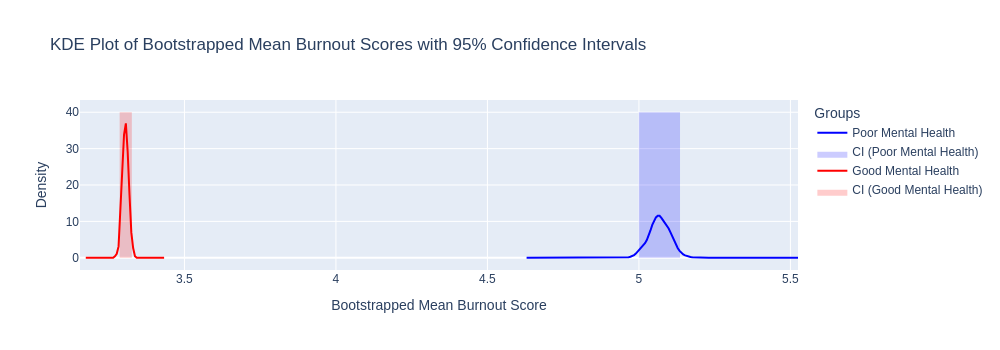

In [58]:
import plotly.graph_objects as go
import numpy as np
from scipy import stats

kde_poor = stats.gaussian_kde(poor_bootstrap_samples)
kde_good = stats.gaussian_kde(good_bootstrap_samples)

# Define x_values explicitly with a broader range for smoother transitions
x_values = np.linspace(3, 6, 500)
bar_height = 40

# Filter x_values for Poor Mental Health KDE
kde_poor_y = kde_poor(x_values)
valid_poor = kde_poor_y > 0  # Set threshold for non-zero density
x_poor_filtered = x_values[valid_poor]
kde_poor_y_filtered = kde_poor_y[valid_poor]

# Filter x_values for Good Mental Health KDE
kde_good_y = kde_good(x_values)
valid_good = kde_good_y > 0  # Set threshold for non-zero density
x_good_filtered = x_values[valid_good]
kde_good_y_filtered = kde_good_y[valid_good]

# Create the plot
fig = go.Figure()

# KDE for Poor Mental Health
fig.add_trace(go.Scatter(x=x_poor_filtered, y=kde_poor_y_filtered, mode='lines',
                         name='Poor Mental Health', line=dict(color='blue')))

# Full height shaded area for Poor Mental Health CI
fig.add_trace(go.Scatter(x=[ci_poor[0], ci_poor[0], ci_poor[1], ci_poor[1]],
                         y=[0, bar_height, bar_height, 0],  # Extend to full height of the graph
                         fill='toself', fillcolor='rgba(0,0,255,0.2)',
                         line=dict(color='rgba(0,0,0,0)'), name="CI (Poor Mental Health)"))

# KDE for Good Mental Health
fig.add_trace(go.Scatter(x=x_good_filtered, y=kde_good_y_filtered, mode='lines',
                         name='Good Mental Health', line=dict(color='red')))

# Full height shaded area for Good Mental Health CI
fig.add_trace(go.Scatter(x=[ci_good[0], ci_good[0], ci_good[1], ci_good[1]],
                         y=[0, bar_height, bar_height, 0],  # Extend to full height of the graph
                         fill='toself', fillcolor='rgba(255,0,0,0.2)',
                         line=dict(color='rgba(0,0,0,0)'), name="CI (Good Mental Health)"))

fig.update_layout(
    title="KDE Plot of Bootstrapped Mean Burnout Scores with 95% Confidence Intervals",
    xaxis_title="Bootstrapped Mean Burnout Score",
    yaxis_title="Density",
    legend_title="Groups",
    width=1000,  # Increase width of the figure
    height=350,   # Adjust height for better proportions
)

fig.show(renderer="png")
